In [15]:
import numpy as np
if not hasattr(np, 'complex'):
    np.complex = complex

import os
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Reshape, Bidirectional, LSTM, Dense
import tensorflow.keras.backend as K

# Clear session
K.clear_session()

# Config
train_audio_path = 'datasets'
labels = os.listdir(train_audio_path) 
all_features = []
all_labels = []
max_pad_len = 100  
n_mfcc = 40


In [16]:
def add_noise(data, noise_level=0.005):
    noise = np.random.randn(len(data))
    return data + noise_level * noise

def shift_audio(data, shift_max=2, sr=8000):
    shift = np.random.randint(sr * shift_max)
    return np.roll(data, shift)

def change_pitch(data, sr=8000, pitch_factor=1.2):
   return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=pitch_factor)

def change_speed(data, speed_factor=1.2):
    return librosa.effects.time_stretch(data, speed_factor)


In [17]:
def extract_mfcc_from_raw(y, sr, max_pad_len=100):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc


In [18]:
def extract_mfcc_from_raw(y, sr, max_pad_len=100):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

for label in labels:
    files = [f for f in os.listdir(os.path.join(train_audio_path, label)) if f.lower().endswith('.wav')]
    for file in files:
        file_path = os.path.join(train_audio_path, label, file)

        # Load original audio
        y, sr = librosa.load(file_path, sr=8000)

        # 1. Original
        mfcc_orig = extract_mfcc_from_raw(y, sr)
        all_features.append(mfcc_orig)
        all_labels.append(label)

        # 2. Noise
        y_noise = add_noise(y)
        mfcc_noise = extract_mfcc_from_raw(y_noise, sr)
        all_features.append(mfcc_noise)
        all_labels.append(label)

        # 3. Pitch shift
        y_pitch = change_pitch(y, sr)
        mfcc_pitch = extract_mfcc_from_raw(y_pitch, sr)
        all_features.append(mfcc_pitch)
        all_labels.append(label)

        # 4. Time shift
        y_shift = shift_audio(y, sr=sr)
        mfcc_shift = extract_mfcc_from_raw(y_shift, sr)
        all_features.append(mfcc_shift)
        all_labels.append(label)

        # 5. Speed change
        try:
            y_speed = change_speed(y, 1.1)
            mfcc_speed = extract_mfcc_from_raw(y_speed, sr)
            all_features.append(mfcc_speed)
            all_labels.append(label)
        except:
            pass 


In [19]:
from collections import Counter

label_counts = Counter(all_labels)

print("Class Distribution (after augmentation):\n")
for label, count in label_counts.items():
    print(f"Class '{label}': {count} samples")

print(f"\nTotal samples: {sum(label_counts.values())}")
print(f"Total classes: {len(label_counts)}")


Class Distribution (after augmentation):

Class 'A': 600 samples
Class 'Ba': 604 samples
Class 'Be': 404 samples
Class 'Bi': 404 samples
Class 'Bo': 404 samples
Class 'Bu': 408 samples
Class 'Da': 604 samples
Class 'De': 404 samples
Class 'Di': 404 samples
Class 'Do': 436 samples
Class 'Du': 404 samples
Class 'E': 604 samples
Class 'Ga': 604 samples
Class 'Ge': 404 samples
Class 'Gi': 404 samples
Class 'Go': 404 samples
Class 'Gu': 404 samples
Class 'Ha': 604 samples
Class 'He': 400 samples
Class 'Hi': 400 samples
Class 'Ho': 404 samples
Class 'Hu': 400 samples
Class 'I': 604 samples
Class 'KA': 624 samples
Class 'Ke': 400 samples
Class 'Ki': 400 samples
Class 'Ko': 400 samples
Class 'Ku': 400 samples
Class 'LA': 604 samples
Class 'Le': 400 samples
Class 'Li': 400 samples
Class 'Lo': 400 samples
Class 'Lu': 400 samples
Class 'MA': 604 samples
Class 'Me': 400 samples
Class 'Mi': 400 samples
Class 'Mo': 400 samples
Class 'Mu': 400 samples
Class 'Na': 604 samples
Class 'Ne': 400 samples
C

In [20]:
le = LabelEncoder()
X = np.array(all_features)
X = X.reshape(-1, n_mfcc, max_pad_len, 1)
y = to_categorical(le.fit_transform(all_labels), num_classes=len(le.classes_))

In [21]:
x_tr, x_temp, y_tr, y_temp = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)
x_val, x_te, y_val, y_te = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=777)


In [51]:
inputs = Input(shape=(n_mfcc, max_pad_len, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Reshape((25, -1))(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64))(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40, 100, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 40, 100, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 100, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 25, 640)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 25, 128)             │         360,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 80)                  │          10,320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 505,808 (1.93 MB)

 Trainable params: 505,616 (1.93 MB)

 Non-trainable params: 192 (768.00 B)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Create output directory
os.makedirs("checkpoints", exist_ok=True)

# Set up callbacks
checkpoint = ModelCheckpoint("checkpoints/best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    x_tr, y_tr,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, earlystop]
)


Epoch 1/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.2371 - loss: 2.8582
Epoch 1: val_accuracy improved from -inf to 0.78801, saving model to checkpoints/best_model.keras
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 881s 707ms/step - accuracy: 0.2373 - loss: 2.8575 - val_accuracy: 0.7880 - val_loss: 0.6695
Epoch 2/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7127 - loss: 0.8667
Epoch 2: val_accuracy improved from 0.78801 to 0.87811, saving model to checkpoints/best_model.keras
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 856s 697ms/step - accuracy: 0.7128 - loss: 0.8666 - val_accuracy: 0.8781 - val_loss: 0.3735
Epoch 3/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.8242 - loss: 0.5298
Epoch 3: val_accuracy improved from 0.87811 to 0.91500, saving model to checkpoints/best_model.keras
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 857s 698ms/step - accuracy: 0.8242 - loss: 0.5298 - val_accuracy: 0.9150 - val_loss: 0.2585
Epoch 4/50
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - acc

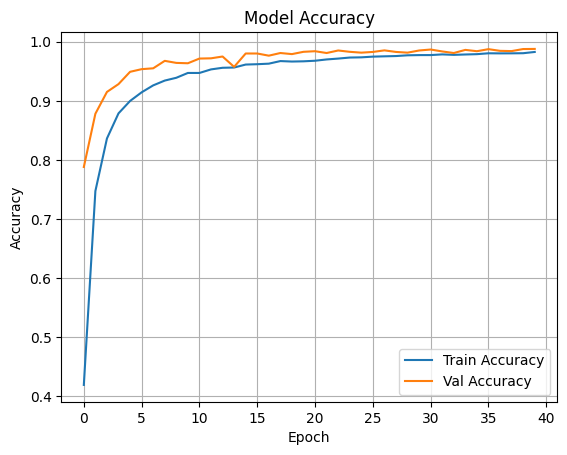

In [53]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()



In [54]:
# Assuming `history` is the object returned by model.fit()
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

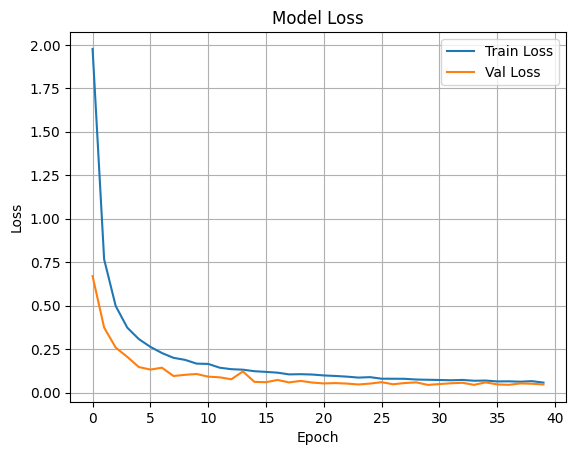

In [55]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [22]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Load the best model
model = load_model('checkpoints/best_model.keras')

# Evaluate the model
loss, accuracy = model.evaluate(x_te, y_te)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Get predictions
y_pred = model.predict(x_te)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_te, axis=1)  # assuming one-hot encoded

# Generate classification report
report = classification_report(y_true, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Save to CSV file
report_df.to_csv('classification_report.csv')
print("Classification report saved as 'classification_report.csv'")


123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.9942 - loss: 0.0190
Test Accuracy: 0.9924
Test Loss: 0.0239
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 226ms/step
Classification report saved as 'classification_report.csv'


In [23]:
import numpy as np

# 1. Predict probabilities from your Keras model
y_pred_probs = model.predict(x_te)

# 2. Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convert y_te (true labels) to class labels if one-hot encoded
if y_te.ndim > 1:  # i.e., it's one-hot
    y_true = np.argmax(y_te, axis=1)
else:
    y_true = y_te


123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step


123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step


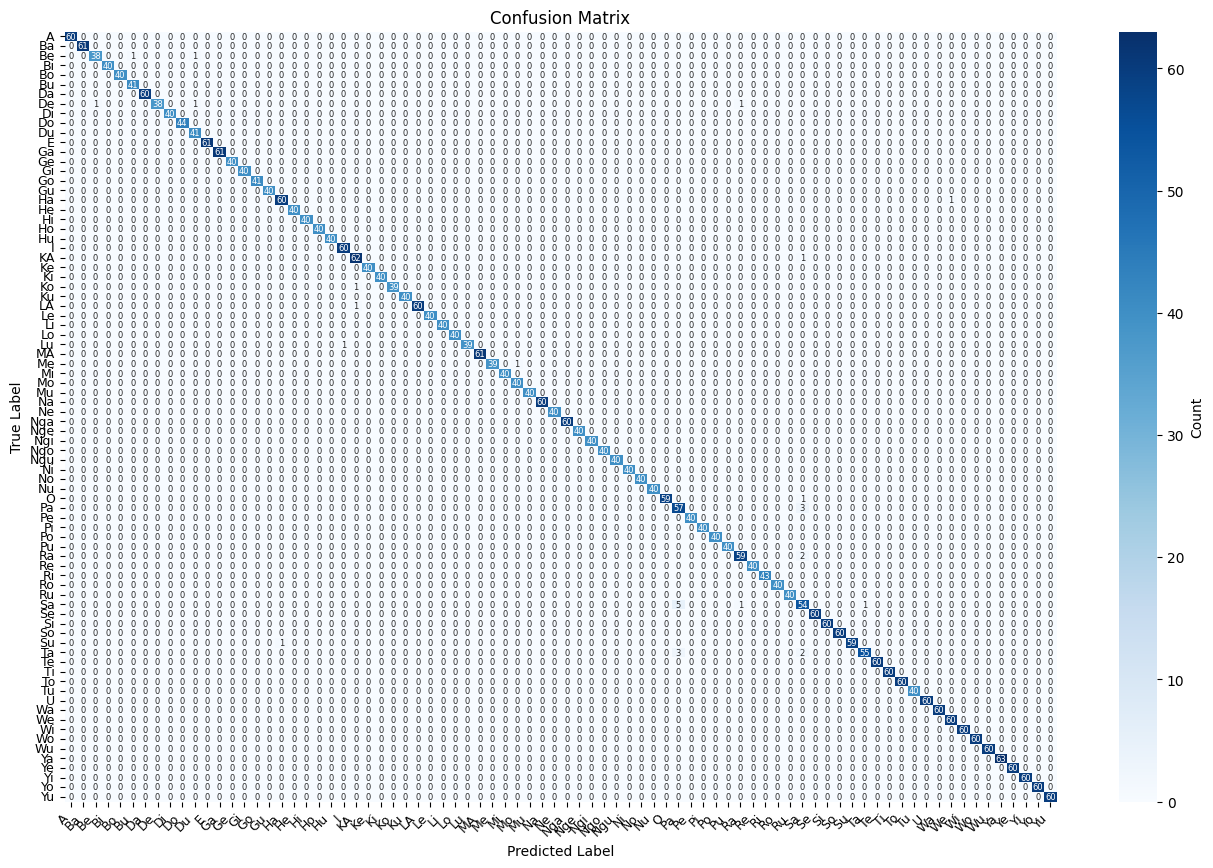

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predicted probabilities from model
y_pred_probs = model.predict(x_te)

# Convert one-hot encoded y_true and predicted probabilities to label indices
y_true_labels = np.argmax(y_te, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Get class names from the label encoder
class_names = le.classes_

# --- Confusion Matrix ---
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(16, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, annot_kws={'size': 6})

# Adjust labels for readability
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [68]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        76
          Ba       1.00      1.00      1.00        76
          Be       0.94      0.96      0.95        50
          Bi       1.00      0.98      0.99        50
          Bo       0.98      1.00      0.99        50
          Bu       0.94      0.98      0.96        51
          Da       1.00      1.00      1.00        76
          De       1.00      0.92      0.96        50
          Di       1.00      1.00      1.00        50
          Do       1.00      1.00      1.00        54
          Du       0.96      0.94      0.95        50
           E       1.00      0.99      0.99        76
          Ga       1.00      1.00      1.00        76
          Ge       1.00      1.00      1.00        50
          Gi       1.00      1.00      1.00        50
          Go       1.00      1.00      1.00        50
          Gu       1.00      1.00      1.00        50
   

In [61]:
import librosa
import numpy as np

def predict_audio(file_path, model, le, sr=8000, max_pad_len=100):
    # Load and preprocess audio
    y, _ = librosa.load(file_path, sr=sr)
    
    # Extract MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    
    # Reshape for model input
    mfcc = mfcc.reshape(1, 40, max_pad_len, 1)

    # Predict
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction)
    predicted_label = le.classes_[predicted_index]
    
    # Confidence
    confidence = prediction[0][predicted_index]

    return predicted_label, confidence


In [65]:
file_path = "datasets/Ta/Ta_100.wav" 
label, confidence = predict_audio(file_path, model, le)

print(f"Predicted Label: {label}")
print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Label: Ta
Confidence: 1.00


In [6]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path='checkpoints/best_model.tflite')
interpreter.allocate_tensors()